# Datacrunch hackathon code snippets

This notebook is a summary of the code I used for the 4 rounds of the december 2020 [datacrunch hackathon](https://datacrunch.com/)

It contains some code for model selection, parameter tunning, feature selection, data visualisation

This code allowed me to perform relatively well during the 4 sessions without doing much data science (around top 10 prediction)

## Data visualisation with seetviz

This give a nice feature visualisation: see [sweetviz](https://pypi.org/project/sweetviz/)

In [1]:
import sweetviz as sv

# Taking a pandas dataframe with features and labels
def report_data(data, report_name):
    my_report = sv.analyze([data, report_name])
    my_report.show_html(f"{report_name}.html")

## Selecting PCA number of components


In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# data is a pandas DataFrame with features
def show_pca(data):
    pca = PCA()
    pca.fit(data)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))

## Data viualisation with TSNE and seaborn

In [3]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

name = 'features_set_1'

# Store tsne results as the computation can be a bit long
# data is a pandas dataframe of the features assuming a correct number of feature ~< 50
# PCA can be used to reduce the features dimensions first
def store_tsne_results(data):
    df_subset = pd.DataFrame()
    tsne_results = TSNE(n_components=2, verbose=1).fit_transform(data)
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
    df_subset.to_csv(f'tsne_{name}.csv')

# Plot the tnse visualisation
# labels is an iterable of integer categorical labels 
def plot_tsne_results(labels):
    # Loading the previously computed tsne components
    df_subset = pd.read_csv(f'tsne_{name}.csv')

    # Adding the labels and the number of categories
    df_subset['y'] = labels
    num_unique_labels = df_subset.y.nunique()

    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("hls", num_unique_labels),
        data=df_subset,
        legend="full",
        alpha=0.3
    )

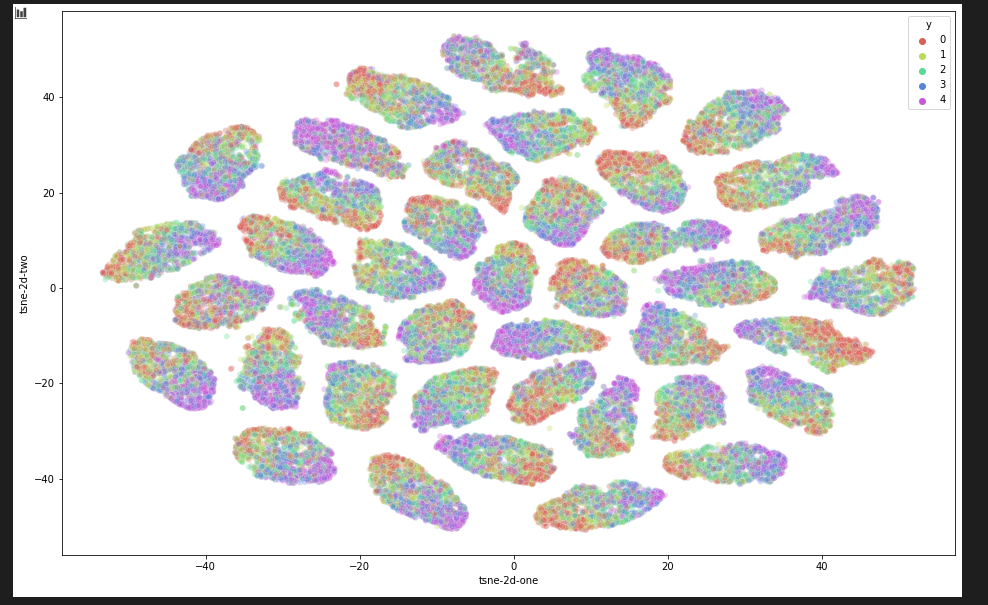

In [4]:
from IPython.display import Image # Using ipython to display images in gitlab too
Image(filename='img/TSNE.png', width=500)
# This is an example comuted during the hackathon.
# Is shows some kind of by month linear relationship (on a dataset with monthly features)

## Adding polynomial features on certain features

In [5]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# data is a pandas DataFrame, poly_cols a list of existing column names
def add_polynomial_features(data, poly_cols):
    pl = PolynomialFeatures(include_bias=False)
    pl_new_cols = pl.fit_transform(data[poly_cols])
    pl_new_cols = pd.DataFrame(pl_new_cols, columns=pl.get_feature_names(poly_cols))
    data.drop(columns=poly_cols, inplace=True)
    return pd.concat([data, pl_new_cols], axis=1)

df = pd.DataFrame()
df['one'] = [1, 2, 3, 4]
df['two'] = [4, 3, 4, 5]
df['stay'] = [1, 1, 1, 1]
add_polynomial_features(df, ['one', 'two'])

stay  one  two  one^2  one two  two^2
0     1  1.0  4.0    1.0      4.0   16.0
1     1  2.0  3.0    4.0      6.0    9.0
2     1  3.0  4.0    9.0     12.0   16.0
3     1  4.0  5.0   16.0     20.0   25.0

## One hot encoding of certain features

In [6]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# data is a pandas DataFrame, categorical_columns a list of existing column names
def one_hot_encode(data, categorical_columns):
    oh = OneHotEncoder(sparse=False)
    one_hot = oh.fit_transform(data[categorical_columns])
    one_hot = pd.DataFrame(one_hot, columns=oh.get_feature_names(categorical_columns))
    one_hot = one_hot.astype('int32')
    data.drop(columns=categorical_columns, inplace=True)
    return pd.concat([data, one_hot], axis=1)

df = pd.DataFrame()
df['cat'] = [1, 2, 3, 3]
df['is_a'] = ['cat', 'dog', 'cat', 'dog']
df['num'] = [0.1, 0.2, 0.01, 0.0]
one_hot_encode(df, ['cat', 'is_a'])

num  cat_1  cat_2  cat_3  is_a_cat  is_a_dog
0  0.10      1      0      0         1         0
1  0.20      0      1      0         0         1
2  0.01      0      0      1         1         0
3  0.00      0      0      1         0         1

## Custom scoring function for cross validation

The hackathon team used the spearmanr corellation in the leaderboard so let's use some code to have a matching local cross validation

In [7]:
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer

def sprmn_score(y1, y2):
    sc, _ = spearmanr(y1, y2)
    sc = 0.0 if np.isnan(sc) else sc
    return sc * 100

sprmn_scorer = make_scorer(sprmn_score, greater_is_better=True)

## Model selection and parameter tunning

This code allows to automatically train models and setup parameter tunning using the [optuna parameter optimisation framework](https://optuna.org/)

In [8]:
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor

from optuna import Trial
from optuna.samplers import TPESampler
import optuna

# Collection of algos to try and optimize:
# [
#   (algo class, optuna trial suggestion dict generator, parameters if no tuning),
# ]
algos_reg = [
    (
        XGBRegressor,
        lambda trial: {
            'max_depth':trial.suggest_int('max_depth', 4, 12),
            "n_estimators" : trial.suggest_int('n_estimators', 50, 500),
            'learning_rate':trial.suggest_discrete_uniform('learning_rate', 0.01, 0.99, 0.02),
            'min_child_weight':trial.suggest_discrete_uniform('min_child_weight', 0.0, 10, 0.5),
            'gamma':trial.suggest_categorical('gamma', [0.0, 0.01, 0.1, 0.5, 1, 3]),
            'tree_method': trial.suggest_categorical('tree_method', ['hist'])
        },
        {}
    ), (
        RandomForestRegressor,
        lambda trial: {
            "n_estimators" : trial.suggest_int('n_estimators', 50, 700),
            'max_depth': trial.suggest_categorical('max_depth', [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, None]),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 6),
            'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
            'n_jobs':  trial.suggest_categorical('n_jobs', [-1]),
        },
        {'n_jobs': -1}
    ), (
        SGDRegressor,
        lambda trial: {
            'random_state': trial.suggest_categorical('random_state', [0, 1, 2, 3, 4, 5, 6, 8, 12, 24]),
            'alpha': trial.suggest_categorical('alpha', [0.0001, 0.0005, 0.0008, 0.001, 0.002, 0.005, 0.1, 1, 10]),
            'loss': trial.suggest_categorical('loss', ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']),
            'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
            'max_iter': trial.suggest_int('max_iter', 500, 2000),
            'tol':trial.suggest_discrete_uniform('tol', 1e-4, 1e-1, 0.001),
            'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']),
            'early_stopping': trial.suggest_categorical('early_stopping', [True, False]),
            'average': trial.suggest_int('average', 0, 100),
        },
        {}
    )
]

# Function to train and get the best model parameters.
# taking advantage of python closures for fast code change, this is usefull for 2 days hackathons
# X y, features and labels
# n_trials number of optuna search trials
# alg_mask: Boolean list to skip some algos (same lenght than the algos_reg list)
# tune_params, Boolean to enable parameter tuning
def get_models(X, y, n_trials=20, alg_mask=None, tune_params=False):
    models = []
    for i, (alg_class, params_gen, prms_dft) in enumerate(algos_reg):
        if alg_mask is not None and not alg_mask[i]:
            print(f'Skipped {alg_class.__name__}')
            continue

        def launch_study(n_trials=n_trials, prms=None, title=None):
            # Print the current study for logging
            title_suffix = '' if title is None else f'_{title}'
            title = alg_class.__name__ + title_suffix
            print(title)

            def objective(trial, X, y):
                params = params_gen(trial) if prms is None else prms
                clf = alg_class(**params)
                return cross_val_score(clf, X, y, cv=5, scoring=sprmn_scorer).mean()

            # Launch the optuna search
            study = optuna.create_study(direction='maximize', sampler=TPESampler())
            study.optimize(lambda trial : objective(trial, X, y), n_trials=n_trials)

            # Collecting the best trial of the search
            clf = alg_class(**study.best_trial.params)
            models.append((clf, title))

        if tune_params:
            launch_study(title='tuned')
        else:
            launch_study(n_trials=1, prms=prms_dft)

    return np.asarray(models)